<a href="https://colab.research.google.com/github/SebastianJanampa/LINEA/blob/master/LINEA_tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!git clone https://github.com/SebastianJanampa/LINEA.git
%cd LINEA
!pip install -r requirements.txt
%cd ..
%cp LINEA/examples/example1.jpg example1.jpg

In [2]:
from LINEA.models.linea.hgnetv2 import build_hgnetv2
from LINEA.models.linea.hybrid_encoder_asymmetric_conv import build_hybrid_encoder_with_asymmetric_conv
from LINEA.models.linea.decoder import build_decoder
from LINEA.models.linea.linea import LINEA, PostProcess

def build_model(args):
  backbone = build_hgnetv2(args)
  encoder = build_hybrid_encoder_with_asymmetric_conv(args)
  decoder = build_decoder(args)
  model = LINEA(backbone, encoder, decoder)
  post_process = PostProcess()
  return model, post_process

In [3]:
LINEA_MODELS = {
    'n': './LINEA/configs/linea/linea_hgnetv2_n.py',
    's': './LINEA/configs/linea/linea_hgnetv2_s.py',
    'm': './LINEA/configs/linea/linea_hgnetv2_m.py',
    'l': './LINEA/configs/linea/linea_hgnetv2_l.py'
}

model_size = 'l'

In [4]:
from LINEA.util.slconfig import DictAction, SLConfig

cfg = SLConfig.fromfile(LINEA_MODELS[model_size])
cfg.pretrained = False

In [12]:
import torch
from torch import nn

weigths_folder = './weights'
download_url = f"https://github.com/SebastianJanampa/storage/releases/download/LINEA/linea_hgnetv2_{model_size}.pth"
state = torch.hub.load_state_dict_from_url(download_url, map_location='cpu', model_dir=weigths_folder)

In [13]:
model, postprocessor = build_model(cfg)
checkpoint = torch.load(f"{weigths_folder}/linea_hgnetv2_{model_size}.pth", map_location='cpu')
model.load_state_dict(checkpoint['model'], strict=True)

class Model(nn.Module):
  def __init__(self):
    super().__init__()
    self.model = model.deploy()
    self.postprocessor = postprocessor.deploy()

  def forward(self, images, orig_target_sizes):
    outputs = self.model(images)
    outputs = self.postprocessor(outputs, orig_target_sizes)
    return outputs

model = Model()

<ipython-input-13-9a1ac3f5b74a>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(f"{weigths_folder}/linea_hgnetv2_{model_size}.pth", map_location='cp

In [11]:
import torchvision.transforms as T
from PIL import Image, ImageDraw

def draw(images, lines, scores, thrh):
    for i, im in enumerate(images):
        draw = ImageDraw.Draw(im)

        scr = scores[i]
        line = lines[i][scr > thrh]
        scrs = scr[scr > thrh]

        for j, l in enumerate(line):
            draw.line(list(l), fill="red", width=5)
            draw.text(
                (l[0], l[1]),
                text=f"{round(scrs[j].item(), 2)}",
                fill="blue",
            )

    return images


transforms = T.Compose(
        [
            T.Resize((640, 640)),
            T.ToTensor(),
            T.Normalize(mean=[0.538, 0.494, 0.453], std=[0.257, 0.263, 0.273]),
        ]
    )

In [19]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model.to(device)
model.eval()

img_file = 'example1.jpg'
im_pil = Image.open(img_file).convert("RGB")

w, h = im_pil.size
orig_size = torch.tensor([[w, h]]).to(device)

im_data = transforms(im_pil).unsqueeze(0).to(device)

output = model(im_data, orig_size)
lines, scores = output

result_images = draw([im_pil], lines, scores, thrh=0.4)

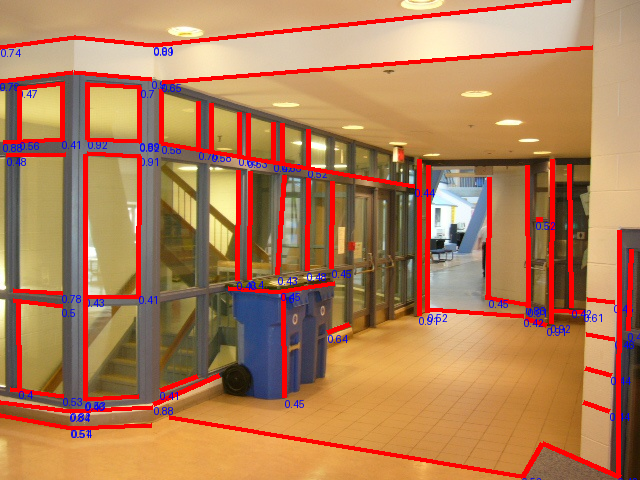

In [20]:
result_images[0]